#Dataset Set Up (package and file imports)

In [62]:
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Part I (Relational)

## 1: Loading all data into a duckdb database

In [63]:
conn = duckdb.connect('/content/drive/MyDrive/Northwestern Data/Sophomore/Spring/DATA300/Homework/Homework2_HealthcareDatabase/hospital_records.db', read_only=False)

In [64]:
conn.execute("""
    CREATE OR REPLACE TABLE ADMISSIONS AS
    SELECT * FROM read_csv_auto('/content/drive/MyDrive/Northwestern Data/Sophomore/Spring/DATA300/Homework/Homework2_HealthcareDatabase/ADMISSIONS.csv');
""")

conn.execute("""
    CREATE OR REPLACE TABLE ICUSTAYS AS
    SELECT * FROM read_csv_auto('/content/drive/MyDrive/Northwestern Data/Sophomore/Spring/DATA300/Homework/Homework2_HealthcareDatabase/ICUSTAYS.csv');
""")

conn.execute("""
    CREATE OR REPLACE TABLE PATIENTS AS
    SELECT * FROM read_csv_auto('/content/drive/MyDrive/Northwestern Data/Sophomore/Spring/DATA300/Homework/Homework2_HealthcareDatabase/PATIENTS.csv');
""")

conn.execute("""
    CREATE OR REPLACE TABLE PROCEDURES_ICD AS
    SELECT * FROM read_csv_auto('/content/drive/MyDrive/Northwestern Data/Sophomore/Spring/DATA300/Homework/Homework2_HealthcareDatabase/PROCEDURES_ICD.csv');
""")

conn.execute("""
    CREATE OR REPLACE TABLE D_ICD_PROCEDURES AS
    SELECT * FROM read_csv_auto('/content/drive/MyDrive/Northwestern Data/Sophomore/Spring/DATA300/Homework/Homework2_HealthcareDatabase/D_ICD_PROCEDURES.csv');
""")

conn.execute("""
    CREATE OR REPLACE TABLE DRGCODES AS
    SELECT * FROM read_csv_auto('/content/drive/MyDrive/Northwestern Data/Sophomore/Spring/DATA300/Homework/Homework2_HealthcareDatabase/DRGCODES.csv');
""")

conn.execute("""
    CREATE OR REPLACE TABLE PRESCRIPTIONS AS
    SELECT * FROM read_csv_auto('/content/drive/MyDrive/Northwestern Data/Sophomore/Spring/DATA300/Homework/Homework2_HealthcareDatabase/PRESCRIPTIONS.csv');
""")

In [65]:
conn.sql('SHOW TABLES;')

┌───────────────────────┐
│         name          │
│        varchar        │
├───────────────────────┤
│ ADMISSIONS            │
│ ADMISSIONS_WITH_AGE   │
│ DRGCODES              │
│ D_ICD_PROCEDURES      │
│ ICUSTAYS              │
│ PATIENTS              │
│ PRESCRIPTIONS         │
│ PRESCRIPTIONS_CLEANED │
│ PROCEDURES_ICD        │
└───────────────────────┘

## Analysis questions

### 1: Medication Usage Patterns by Ethnic Group

In [66]:
conn.sql(
    """
    SELECT
        PRESCRIPTIONS.subject_id,
        PRESCRIPTIONS.dose_unit_rx,
        ADMISSIONS.ethnicity
    FROM PRESCRIPTIONS
    JOIN ADMISSIONS
      ON PRESCRIPTIONS.subject_id = ADMISSIONS.subject_id
    LIMIT 5;
    """
)

┌────────────┬──────────────┬───────────┐
│ subject_id │ dose_unit_rx │ ethnicity │
│   int64    │   varchar    │  varchar  │
├────────────┼──────────────┼───────────┤
│      42458 │ mL           │ WHITE     │
│      42458 │ mg           │ WHITE     │
│      42458 │ mg           │ WHITE     │
│      42458 │ TAB          │ WHITE     │
│      42458 │ mg           │ WHITE     │
└────────────┴──────────────┴───────────┘

In [67]:
ethnicity_drug_type = conn.sql(
    """
    SELECT
        ethnicity,
        drug_type,
        COUNT(*) AS prescription_count
    FROM (
        SELECT
            PRESCRIPTIONS.subject_id,
            ADMISSIONS.ethnicity,
            CASE
                WHEN route IN ('PO', 'ORAL', 'PO/NG', 'OG', 'NG', 'SL') THEN 'Oral'
                WHEN route IN ('IV', 'IM', 'SC', 'SUBCUT', 'ID', 'IVPCA', 'IV DRIP', 'IV BOLUS', 'IJ', 'PB') THEN 'Injection'
                WHEN route IN ('TP', 'TD', 'IRR', 'REPLACE') THEN 'Topical'
                WHEN route IN ('NEB', 'IH') THEN 'Inhaled'
                WHEN route IN ('LEFT EYE', 'RIGHT EYE', 'BOTH EYES', 'OD', 'OS', 'OU') THEN 'Ophthalmic'
                WHEN route = 'PR' THEN 'Rectal'
                WHEN route = 'J TUBE' THEN 'Enteral (Tube)'
                WHEN route IN ('DIALYS', 'DWELL', 'ED', 'IT', 'NU', 'IR', 'VG') THEN 'Other'
                ELSE 'Unknown'
            END AS drug_type
        FROM PRESCRIPTIONS
        JOIN ADMISSIONS
          ON PRESCRIPTIONS.subject_id = ADMISSIONS.subject_id
        WHERE route IS NOT NULL
    )
    GROUP BY ethnicity, drug_type
    ORDER BY ethnicity, prescription_count DESC
    """
).df()

In [68]:
drug_type_ethnicity_df_non_aggregated = conn.sql(
    """
SELECT
    PRESCRIPTIONS.subject_id,
    PRESCRIPTIONS.hadm_id,
    PRESCRIPTIONS.drug,
    PRESCRIPTIONS.form_unit_disp,
    ADMISSIONS.ethnicity,
    CASE
        WHEN form_unit_disp IN ('TAB', 'CAP', 'PKT', 'TROC', 'LOZ') THEN 'Tablet/Capsule'
        WHEN form_unit_disp IN ('BTL', 'UDCUP') THEN 'Liquid'
        WHEN form_unit_disp IN ('VIAL', 'SYR', 'BAG', 'AMP','mL', 'ml','g','gm') THEN 'Injection/IV'
        WHEN form_unit_disp IN ('INH', 'NEB', 'AERO', 'SPRY','CAN') THEN 'Inhaled'
        WHEN form_unit_disp IN ('PTCH', 'Appl', 'DBTL', 'TUBE', 'DRP') THEN 'Topical'
        WHEN form_unit_disp = 'SUPP' THEN 'Rectal'
        WHEN form_unit_disp IN ('DBTL', 'DRP') THEN 'Eyes'
        ELSE 'Other'
    END AS drug_type
FROM PRESCRIPTIONS
JOIN ADMISSIONS
  ON PRESCRIPTIONS.subject_id = ADMISSIONS.subject_id
  AND PRESCRIPTIONS.hadm_id = ADMISSIONS.hadm_id
WHERE form_unit_disp IS NOT NULL
    """
).df()

In [69]:
#drug_type_ethnicity_df_non_aggregated.to_csv("/content/drive/MyDrive/Northwestern Data/Sophomore/Spring/DATA300/Homework/Homework2_HealthcareDatabase/drug_type_ethnicity_partII_ueb9720.csv", index=False)

In [70]:
drug_type_ethnicity_df = conn.sql(
    """
WITH form_classified AS (
    SELECT
        PRESCRIPTIONS.subject_id,
        ADMISSIONS.ethnicity,
        CASE
            WHEN form_unit_disp IN ('TAB', 'CAP', 'PKT', 'TROC', 'LOZ') THEN 'Tablet/Capsule'
            WHEN form_unit_disp IN ('BTL', 'UDCUP') THEN 'Liquid'
            WHEN form_unit_disp IN ('VIAL', 'SYR', 'BAG', 'AMP','mL', 'ml','g','gm') THEN 'Injection/IV'
            WHEN form_unit_disp IN ('INH', 'NEB', 'AERO', 'SPRY','CAN') THEN 'Inhaled'
            WHEN form_unit_disp IN ('PTCH', 'Appl', 'DBTL', 'TUBE', 'DRP') THEN 'Topical'
            WHEN form_unit_disp = 'SUPP' THEN 'Rectal'
            WHEN form_unit_disp IN ('DBTL', 'DRP') THEN 'Eyes'
            ELSE 'Other'
        END AS drug_type
    FROM PRESCRIPTIONS
    JOIN ADMISSIONS
      ON PRESCRIPTIONS.subject_id = ADMISSIONS.subject_id
      AND PRESCRIPTIONS.hadm_id = ADMISSIONS.hadm_id
    WHERE form_unit_disp IS NOT NULL
)

SELECT
    ethnicity,
    drug_type,
    COUNT(*) AS prescription_count
FROM form_classified
GROUP BY ethnicity, drug_type
ORDER BY ethnicity, prescription_count DESC;
    """
).df()

In [71]:
drug_type_ethnicity_df

,ethnicity,drug_type,prescription_count
0,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Injection/IV,185
1,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Tablet/Capsule,64
2,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Liquid,31
3,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Topical,1
4,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,Rectal,1
5,ASIAN,Injection/IV,120
6,ASIAN,Tablet/Capsule,36
7,ASIAN,Liquid,10
8,ASIAN,Other,6
9,ASIAN,Topical,3


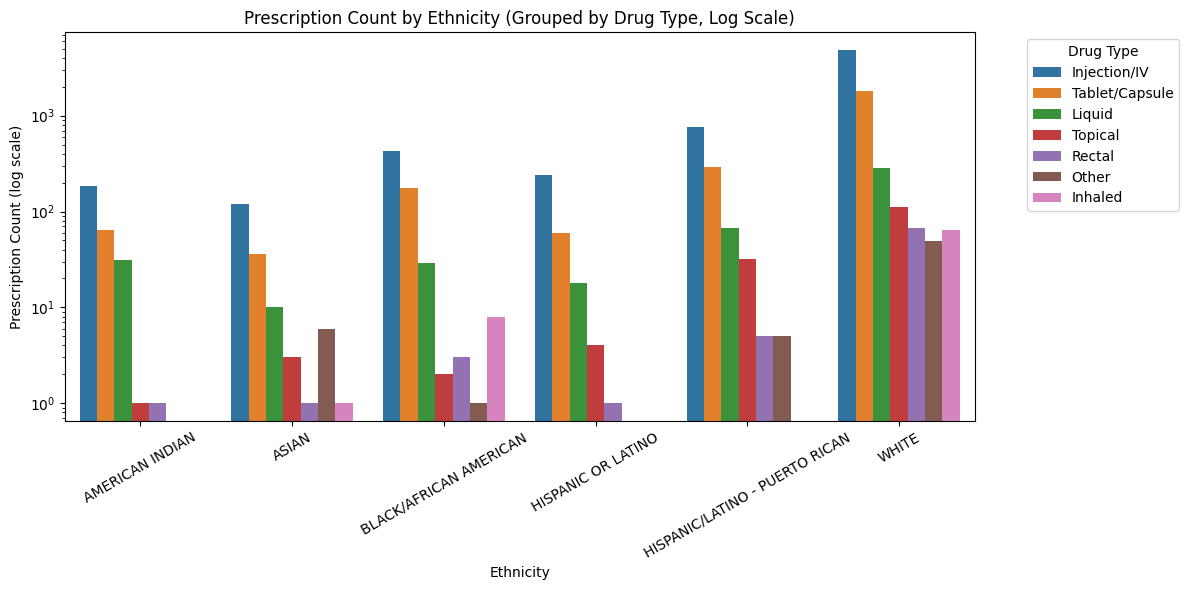

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt


filtered_df = drug_type_ethnicity_df[
    ~drug_type_ethnicity_df["ethnicity"].isin(["OTHER", "UNABLE TO OBTAIN", "UNKNOWN/NOT SPECIFIED"])
].copy()

filtered_df["ethnicity"] = filtered_df["ethnicity"].replace(
    {"AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE": "AMERICAN INDIAN"}
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=filtered_df,
    x="ethnicity",
    y="prescription_count",
    hue="drug_type"
)

plt.yscale("log")
plt.title("Prescription Count by Ethnicity (Grouped by Drug Type, Log Scale)")
plt.xlabel("Ethnicity")
plt.ylabel("Prescription Count (log scale)")
plt.xticks(rotation=30)
plt.legend(title="Drug Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [73]:
conn.sql(
    """
SELECT count(DISTINCT(subject_id)), ethnicity
FROM ADMISSIONS
GROUP BY ethnicity
    """
)

┌────────────────────────────┬──────────────────────────────────────────────────────────┐
│ count(DISTINCT subject_id) │                        ethnicity                         │
│           int64            │                         varchar                          │
├────────────────────────────┼──────────────────────────────────────────────────────────┤
│                          6 │ BLACK/AFRICAN AMERICAN                                   │
│                         10 │ UNKNOWN/NOT SPECIFIED                                    │
│                          2 │ HISPANIC OR LATINO                                       │
│                          3 │ OTHER                                                    │
│                          2 │ ASIAN                                                    │
│                         74 │ WHITE                                                    │
│                          1 │ UNABLE TO OBTAIN                                         │
│         

## 2: Procedures performed on partients by age groups

In [74]:

table_check = conn.sql("""
    SELECT table_name
    FROM information_schema.tables
    WHERE lower(table_name) = 'admissions_with_age'
""").fetchdf()

if table_check.empty:
    conn.sql("""
        CREATE TABLE ADMISSIONS_WITH_AGE AS
        SELECT
            ADMISSIONS.*,
            FLOOR(DATE_DIFF('day', PATIENTS.dob, ADMISSIONS.admittime) / 365.25) AS age_at_admit
        FROM ADMISSIONS
        JOIN PATIENTS ON ADMISSIONS.subject_id = PATIENTS.subject_id
    """)
else:
    print("Table already exists. Skipping creation.")

Table already exists. Skipping creation.


In [75]:
conn.sql(
    """
SELECT
    PROCEDURES_ICD.subject_id,
    PROCEDURES_ICD.hadm_id,
    PROCEDURES_ICD.icd9_code,
    PROCEDURES_ICD.seq_num,
    D_ICD_PROCEDURES.long_title AS procedure_title,
    ADMISSIONS_WITH_AGE.age_at_admit,
    CASE
        WHEN age_at_admit <= 19 THEN '0-19'
        WHEN age_at_admit BETWEEN 20 AND 49 THEN '20-49'
        WHEN age_at_admit BETWEEN 50 AND 79 THEN '50-79'
        WHEN age_at_admit >= 80 THEN '80+'
        ELSE 'Unknown'
    END AS age_group
FROM PROCEDURES_ICD
JOIN ADMISSIONS_WITH_AGE ON PROCEDURES_ICD.hadm_id = ADMISSIONS_WITH_AGE.hadm_id
JOIN D_ICD_PROCEDURES ON PROCEDURES_ICD.icd9_code = D_ICD_PROCEDURES.icd9_code
    """
).df()#.to_csv("/content/drive/MyDrive/Northwestern Data/Sophomore/Spring/DATA300/Homework/Homework2_HealthcareDatabase/admissions_with_age_partII_ueb9720.csv", index=False)

In [76]:
conn.sql(
    """
    SELECT *
    FROM (
        SELECT
            D_ICD_PROCEDURES.long_title AS procedure_title,
            CASE
                WHEN age_at_admit <= 19 THEN '0–19'
                WHEN age_at_admit BETWEEN 20 AND 49 THEN '20–49'
                WHEN age_at_admit BETWEEN 50 AND 79 THEN '50–79'
                WHEN age_at_admit >= 80 THEN '80+'
                ELSE 'Unknown'
            END AS age_group,
            COUNT(*) AS procedure_count,
            RANK() OVER (
                PARTITION BY
                    CASE
                        WHEN age_at_admit <= 19 THEN '0–19'
                        WHEN age_at_admit BETWEEN 20 AND 49 THEN '20–49'
                        WHEN age_at_admit BETWEEN 50 AND 79 THEN '50–79'
                        WHEN age_at_admit >= 80 THEN '80+'
                        ELSE 'Unknown'
                    END
                ORDER BY COUNT(*) DESC
            ) AS procedure_rank
        FROM PROCEDURES_ICD
        JOIN ADMISSIONS_WITH_AGE ON PROCEDURES_ICD.hadm_id = ADMISSIONS_WITH_AGE.hadm_id
        JOIN D_ICD_PROCEDURES ON PROCEDURES_ICD.ICD9_CODE = D_ICD_PROCEDURES.ICD9_CODE
        GROUP BY
            D_ICD_PROCEDURES.long_title,
            CASE
                WHEN age_at_admit <= 19 THEN '0–19'
                WHEN age_at_admit BETWEEN 20 AND 49 THEN '20–49'
                WHEN age_at_admit BETWEEN 50 AND 79 THEN '50–79'
                WHEN age_at_admit >= 80 THEN '80+'
                ELSE 'Unknown'
            END
    )
    WHERE procedure_rank <= 3
    ORDER BY age_group, procedure_rank;
    """
).df()

,procedure_title,age_group,procedure_count,procedure_rank
0,"Venous catheterization, not elsewhere classified",0–19,3,1
1,Closure of skin and subcutaneous tissue of oth...,0–19,2,2
2,Enteral infusion of concentrated nutritional s...,0–19,1,3
3,Temporary tracheostomy,0–19,1,3
4,Transfusion of packed cells,0–19,1,3
5,Closed reduction of fracture without internal ...,0–19,1,3
6,Open reduction of fracture with internal fixat...,0–19,1,3
7,"Removal of implanted devices from bone, femur",0–19,1,3
8,Other skeletal traction,0–19,1,3
9,"Other cervical fusion of the posterior column,...",0–19,1,3


##3: ICU Duration Summary

In [77]:
conn.sql(
    """
SELECT * FROM ADMISSIONS LIMIT 1;
    """
)

┌────────┬────────────┬─────────┬─────────────────────┬─────────────────────┬───────────┬────────────────┬──────────────────────┬────────────────────┬───────────┬──────────┬──────────┬────────────────┬────────────────────────┬─────────────────────┬─────────────────────┬───────────┬──────────────────────┬──────────────────────┐
│ row_id │ subject_id │ hadm_id │      admittime      │      dischtime      │ deathtime │ admission_type │  admission_location  │ discharge_location │ insurance │ language │ religion │ marital_status │       ethnicity        │      edregtime      │      edouttime      │ diagnosis │ hospital_expire_flag │ has_chartevents_data │
│ int64  │   int64    │  int64  │      timestamp      │      timestamp      │ timestamp │    varchar     │       varchar        │      varchar       │  varchar  │ varchar  │ varchar  │    varchar     │        varchar         │      timestamp      │      timestamp      │  varchar  │        int64         │        int64         │
├────────┼───

In [78]:
icu_duration_df = conn.sql(
    """
SELECT
    ICUSTAYS.subject_id,
    ICUSTAYS.hadm_id,
    ICUSTAYS.icustay_id,
    ICUSTAYS.intime,
    ICUSTAYS.outtime,
    PATIENTS.gender,
    ADMISSIONS.ethnicity,
    DATE_DIFF('second', ICUSTAYS.intime, ICUSTAYS.outtime) / 3600.0 AS icu_stay_hours,
    LOG10(DATE_DIFF('second', ICUSTAYS.intime, ICUSTAYS.outtime) / 3600.0) AS log_icu_stay_hours
FROM ICUSTAYS
JOIN PATIENTS ON ICUSTAYS.subject_id = PATIENTS.subject_id
JOIN ADMISSIONS ON ICUSTAYS.hadm_id = ADMISSIONS.hadm_id
    """
).df()

In [79]:
#icu_duration_df.to_csv("/content/drive/MyDrive/Northwestern Data/Sophomore/Spring/DATA300/Homework/Homework2_HealthcareDatabase/patient_ICU_duration_partII_ueb9720.csv", index=False)

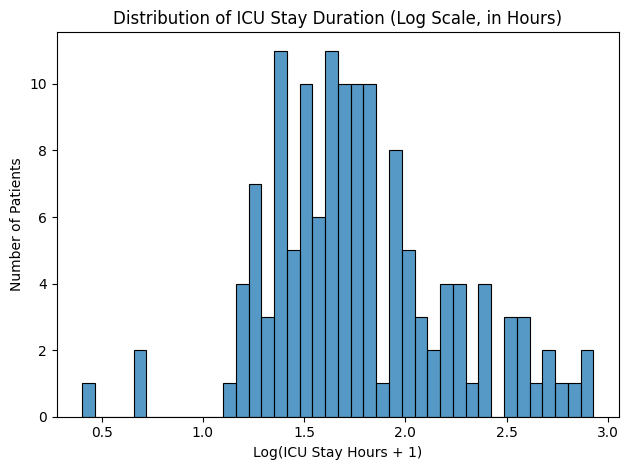

In [80]:
sns.histplot(data=icu_duration_df, x="log_icu_stay_hours", bins=40)
plt.title("Distribution of ICU Stay Duration (Log Scale, in Hours)")
plt.xlabel("Log(ICU Stay Hours + 1)")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.show()

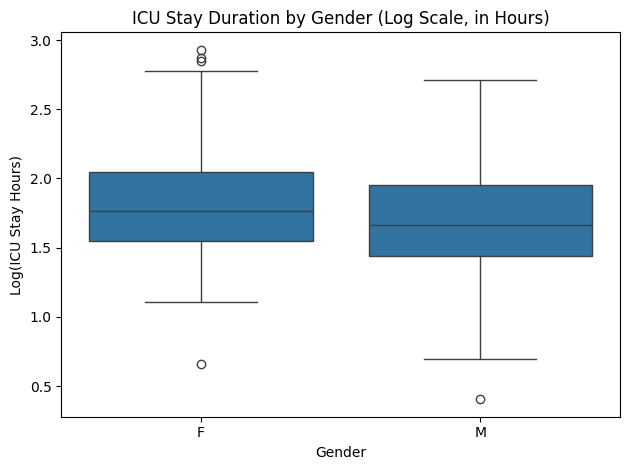

In [81]:
sns.boxplot(data=icu_duration_df, x="gender", y="log_icu_stay_hours")
plt.title("ICU Stay Duration by Gender (Log Scale, in Hours)")
plt.xlabel("Gender")
plt.ylabel("Log(ICU Stay Hours)")
plt.tight_layout()
plt.show()

In [82]:
male_stats = icu_duration_df[icu_duration_df['gender'] == 'M']['icu_stay_hours'].describe()
female_stats = icu_duration_df[icu_duration_df['gender'] == 'F']['icu_stay_hours'].describe()

pd.DataFrame({
    'Male': male_stats,
    'Female': female_stats
})

,Male,Female
count,73.000000,63.000000
mean,84.331986,132.961874
std,100.228997,187.632465
min,2.542222,4.568611
25%,27.538333,35.373750
50%,46.204444,57.735278
75%,89.087778,112.229167
max,513.927500,849.756389


<ipython-input-83-bade4327f8ee>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icu_duration_filtered_df["ethnicity"] = icu_duration_filtered_df["ethnicity"].replace(


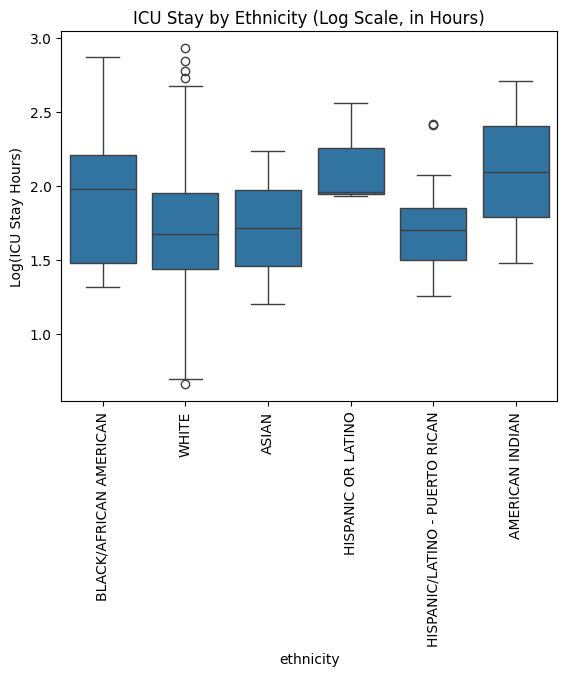

In [83]:
icu_duration_filtered_df = icu_duration_df[~icu_duration_df["ethnicity"].isin([
    "OTHER", "UNABLE TO OBTAIN", "UNKNOWN/NOT SPECIFIED"
])]


icu_duration_filtered_df["ethnicity"] = icu_duration_filtered_df["ethnicity"].replace(
    {"AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE": "AMERICAN INDIAN"}
)

sns.boxplot(data=icu_duration_filtered_df, x="ethnicity", y="log_icu_stay_hours")
plt.xticks(rotation=90)
plt.ylabel("Log(ICU Stay Hours)")
plt.title("ICU Stay by Ethnicity (Log Scale, in Hours)")
plt.show()

In [88]:
conn.close()